In [1]:
!pip install ijson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 4.3 MB/s eta 0:00:00


In [2]:
import numpy as np

import scipy.integrate as integrate
from scipy.integrate import cumulative_trapezoid, solve_ivp
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage import center_of_mass, label, map_coordinates, zoom
from scipy.signal import find_peaks
from scipy.stats import kurtosis, skew
from scipy.optimize import curve_fit, minimize
from scipy import signal
from scipy.ndimage import gaussian_filter1d, uniform_filter1d

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.path import Path
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker

from mpl_toolkits.axes_grid1 import make_axes_locatable

import plotly.graph_objects as go

from typing import Any, Dict, List, Literal, Optional, Tuple, Union

import csv

import json, ijson

import gdown

import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Data preparation

We assign a score to each elevation matrix in the dataset, rating its axial symmetry.

In [ ]:
class PreprocessingConfig:
    """Configuration parameters for volcano axisymmetry analysis."""
    threshold_drop: float = 300.0           # Elevation drop for center finding
    threshold_rise: float = 300.0           # Elevation rise for axial cross-sections extraction
    num_sections: int = 7                   # Number of axial cross-sections
    axial_sections_distance: float = 200.0  # Distance between axial cross-sections
    resolution: int = 500                   # Target resolution for interpolation
    verbose: bool = True                    # Print detailed processing info

class Preprocessor:
    blacklist = ["Chinameca"] # This volcano is recognised as it's neighbour (San Miguel) in the code, because of it low height

    def __init__(self, json_path: str, output_path: str):
        self.json_path = json_path
        self.output_path = output_path
        self.config = PreprocessingConfig()

        logging.basicConfig(level=logging.INFO if self.config.verbose else logging.WARNING, format='%(message)s')
        self.logger = logging.getLogger(__name__)

    def _find_center(self, matrix: np.ndarray) -> Tuple[float, float]:
        max_elev = np.max(matrix)
        threshold = max_elev - self.config.threshold_drop
        mask = matrix > threshold
        geom_center = (matrix.shape[1] / 2.0, matrix.shape[0] / 2.0)
        labeled_mask, num_features = label(mask)
        centroids = center_of_mass(matrix, labeled_mask, range(1, num_features + 1))
        centroids_xy = [(c[1], c[0]) for c in centroids]
        best = min(centroids_xy,
                   key=lambda c: (c[0] - geom_center[0])**2 + (c[1] - geom_center[1])**2)
        return best

    def _crop_matrix(self, matrix: np.ndarray, center: Tuple[float, float]) -> Tuple[np.ndarray, int]:
        x_center, y_center = center
        h, w = matrix.shape
        dists = [int(np.floor(x_center)), int(np.floor(w - 1 - x_center)),
                 int(np.floor(y_center)), int(np.floor(h - 1 - y_center))]
        r = min(dists)
        row_c, col_c = int(np.floor(y_center)), int(np.floor(x_center))
        cropped = matrix[row_c - r:row_c + r, col_c - r:col_c + r]
        return cropped, r

    def _interpolate(self, matrix: np.ndarray, resolution: int = None) -> np.ndarray:
        ny, nx = matrix.shape
        if resolution is None: resolution = self.config.resolution
        zoom_factors = (resolution / ny, resolution / nx)
        return zoom(matrix, zoom_factors, order=1)

    def _extract_axial_sections(self, matrix: np.ndarray, center: Tuple[int, int], num_sections: int) -> Tuple[List[np.ndarray], np.ndarray]:
        max_elev = np.max(matrix)
        min_elev = max(0, np.min(matrix)) + self.config.threshold_rise
        levels = np.arange(max_elev - 100, min_elev - 1, -self.config.axial_sections_distance)[:num_sections]

        ny, nx = matrix.shape
        y_idxs, x_idxs = np.indices((ny, nx))

        cs = plt.contour(x_idxs, y_idxs, matrix, levels=levels[::-1], linewidths=1, colors="black")

        kept_contours = []
        kept_levels = []
        x_center, y_center = center
        boundary_tol = 1e-6

        for lvl_idx, lvl in enumerate(levels[::-1]):
            segments = cs.allsegs[lvl_idx]
            best_seg = None
            best_dist = float("inf")

            for seg in segments:
                xs, ys = seg[:,0], seg[:,1]

                if (
                    np.any(xs <= boundary_tol) or
                    np.any(xs >= (nx - 1 - boundary_tol)) or
                    np.any(ys <= boundary_tol) or
                    np.any(ys >= (ny - 1 - boundary_tol))
                ):
                    continue

                poly_path = Path(seg)
                if not poly_path.contains_point((x_center, y_center)):
                    continue

                centroid = seg.mean(axis=0)
                dx = centroid[0] - x_center
                dy = centroid[1] - y_center
                d2 = dx*dx + dy*dy
                if d2 < best_dist:
                    best_dist = d2
                    best_seg = seg

            if best_seg is not None:
                kept_levels.append(lvl)
                kept_contours.append(best_seg.copy())

        plt.close()
        return kept_contours, np.array(kept_levels)

    def _get_axisymmetry_score(self, axial_sections: List[np.ndarray], center: Tuple[int, int], n_rays: int = 360) -> float:
        x_center, y_center = center
        all_norm_devs = []
        all_weights = []

        angles_bin_edges = np.linspace(0, 2*np.pi, n_rays + 1)

        for seg in axial_sections:
            xs = seg[:, 0] - x_center
            ys = seg[:, 1] - y_center
            radii = np.sqrt(xs*xs + ys*ys)
            thetas = np.arctan2(ys, xs)
            thetas = np.mod(thetas, 2*np.pi)

            mean_r = np.mean(radii)
            if mean_r < 1e-6:
                continue

            r_bin = np.full(n_rays, np.nan, dtype=float)
            for i in range(n_rays):
                θ_min = angles_bin_edges[i]
                θ_max = angles_bin_edges[i+1]
                in_bin = (thetas >= θ_min) & (thetas < θ_max)
                if not np.any(in_bin):
                    continue
                r_bin[i] = np.mean(radii[in_bin])

            valid = ~np.isnan(r_bin)
            if np.count_nonzero(valid) < 3:
                continue
            sampled_r = r_bin[valid]

            l1_dev = np.mean(np.abs(sampled_r - mean_r))
            norm_dev = l1_dev / mean_r
            all_norm_devs.append(norm_dev)

            all_weights.append(mean_r)

        if len(all_norm_devs) == 0:
            return 0.0

        all_norm_devs = np.array(all_norm_devs)
        all_weights = np.array(all_weights)

        weighted_avg_dev = np.sum(all_norm_devs * all_weights) / np.sum(all_weights)

        k = 5.0
        score = np.exp(-k * weighted_avg_dev)
        return float(score)

    def get_axisymmetry_scores(self) -> Dict[str, float]:
        scores: Dict[str, float] = {}
        self.logger.info(f"Loading from {self.json_path}")
        try:
            with open(self.json_path, 'rb') as f:
                count = 0
                for name, data in ijson.kvitems(f, ''):
                    count += 1
                    if name in self.blacklist:
                        scores[name] = 0.0
                        continue
                    matrix = np.array(data, dtype=float)
                    center = self._find_center(matrix)
                    cropped, radius = self._crop_matrix(matrix, center)
                    if cropped.size == 0:
                        scores[name] = 0.0
                        continue
                    interpolated = self._interpolate(cropped)
                    if np.max(interpolated) < 1000:
                        scores[name] = 0.0
                        continue
                    new_center = int(interpolated.shape[0] / 2.0), int(interpolated.shape[1] / 2.0)
                    axial_sections, levels = self._extract_axial_sections(interpolated, new_center, self.config.num_sections)
                    score = self._get_axisymmetry_score(axial_sections, new_center)
                    if self.config.verbose:
                        self.logger.info(f"==={name}===")
                        self.logger.info(f"Initial shape: ({matrix.shape[0]}, {matrix.shape[1]})")
                        self.logger.info(f"Center: ({center[0]:.2f}, {center[1]:.2f})")
                        self.logger.info(f"Crop radius: {radius}")
                        self.logger.info(f"Axisymmetry score: {score:.6f}")
                        self._visualize_center(name, interpolated, new_center)
                        self._plot_contours_with_circles(name, new_center, axial_sections, levels)
                    scores[name] = score
                    if count % 50 == 0:
                        self.logger.info(f"Processed {count} volcanoes...")
                self.logger.info(f"Finished processing!")
        except FileNotFoundError:
            raise

        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        with open(self.output_path, 'w', newline='') as out:
            writer = csv.writer(out)
            writer.writerow(['Volcano_Name', 'Axisymmetry_Score'])
            writer.writerows(sorted_scores)
        self.logger.info("=== Fifteen most axisymmetric stratovolcanoes ===")
        for i, (name, score) in enumerate(sorted_scores[:15], 1):
            self.logger.info(f"{i:2d}. {name:<30} {score:.6f}")
        return scores

    def _visualize_center(self, name: str, matrix: np.ndarray, center: Tuple[int, int], fontsize: int = 10) -> None:
        fig, ax = plt.subplots(figsize=(5, 5))
        im = ax.imshow(matrix, cmap='magma', origin='lower')
        ax.scatter(*center, marker='*', color='black', s=20)
        ax.set_xlabel(r"X [$\text{px}$]", fontsize=fontsize)
        ax.set_ylabel(r"Y [$\text{px}$]", fontsize=fontsize)
        ax.tick_params(labelsize=fontsize)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label(r"elevation [$\text{m}$]", fontsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize)
        #plt.savefig(f'center_{name}.pdf', format='pdf', dpi=300, bbox_inches='tight')
        plt.savefig(f'center_{name}.svg', format='svg', dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_contours_with_circles(self, name:str, center: Tuple[int, int], axial_sections: List[np.ndarray], levels: np.ndarray, fontsize: int = 10) -> None:
        fig, ax = plt.subplots(figsize=(5, 5))
        x_center, y_center = center
        colors_list = plt.cm.magma(np.linspace(0, 1, len(axial_sections)))

        for contour_verts, level, color in zip(axial_sections, levels, colors_list):
            if contour_verts is None or contour_verts.shape[0] == 0:
                continue

            x_vals = contour_verts[:, 0]
            y_vals = contour_verts[:, 1]
            ax.plot(x_vals, y_vals, color=color, linewidth=2, alpha=0.8)

            x_rel = x_vals - x_center
            y_rel = y_vals - y_center
            radii = np.sqrt(x_rel**2 + y_rel**2)
            mean_radius = np.mean(radii)

            θ = np.linspace(0, 2*np.pi, 200)
            circle_x = x_center + mean_radius * np.cos(θ)
            circle_y = y_center + mean_radius * np.sin(θ)
            ax.plot(circle_x, circle_y, color=color, linewidth=1, linestyle='--', alpha=0.6)

        ax.scatter([x_center], [y_center],
                  marker='*', color='black', s=100,
                  edgecolors='white', linewidth=1)
        ax.set_aspect('equal')
        ax.set_xlabel(r"X [$\text{px}$]", fontsize=fontsize)
        ax.set_ylabel(r"Y [$\text{px}$]", fontsize=fontsize)
        ax.tick_params(labelsize=fontsize)

        sm = ScalarMappable(norm=Normalize(vmin=levels.min(), vmax=levels.max()), cmap='magma')
        sm.set_array([])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        cbar = plt.colorbar(sm, cax=cax)
        cbar.set_label(r"elevation [$\mathrm{m}$]", fontsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize)

        ax.grid(True, alpha=0.2)
        fig.tight_layout()
        #plt.savefig(f'axial_sections_{name}.pdf', format='pdf', dpi=300, bbox_inches='tight')
        plt.savefig(f'axial_sections_{name}.svg', format='svg', dpi=300, bbox_inches='tight')
        plt.show()


## DEMO

In [ ]:
file_id = '1hz2XGeUu-Qmhz9Monfv3TJXNR1clsapr'

# just Mayon stratovolcano
#file_id = '17kuoJm5_mTHElpRK-vDDJm29LM21-KVn'

gdown.download(f'https://drive.google.com/uc?id={file_id}', 'stratovolcanoes_demo.json', quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1hz2XGeUu-Qmhz9Monfv3TJXNR1clsapr
To: /content/stratovolcanoes_demo.json
100%|██████████| 13.7M/13.7M [00:00<00:00, 80.9MB/s]


'stratovolcanoes_demo.json'

Loading from stratovolcanoes_demo.json
===Acamarachi===
Initial shape: (580, 627)
Center: (315.53, 267.28)
Crop radius: 267
Axisymmetry score: 0.351227


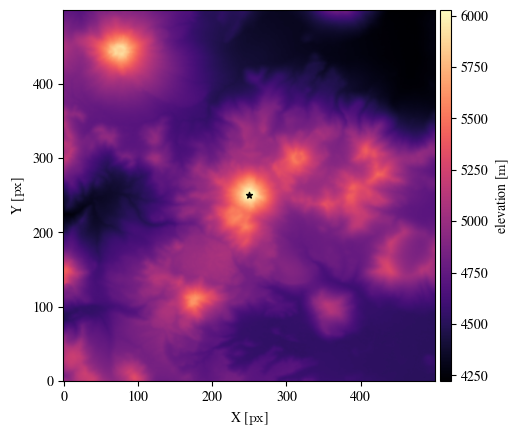

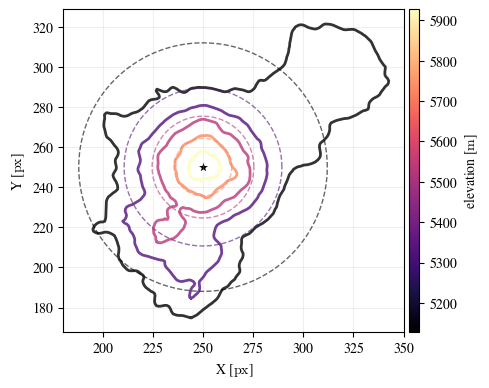

===Acatenango===
Initial shape: (580, 595)
Center: (299.38, 283.11)
Crop radius: 283
Axisymmetry score: 0.294254


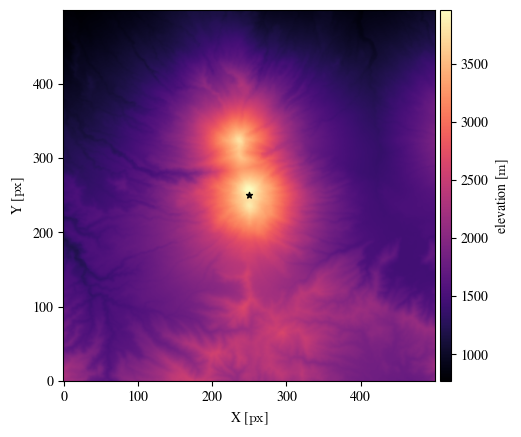

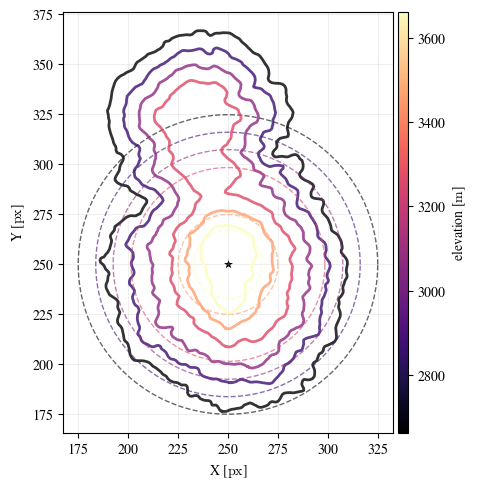

===Acotango===
Initial shape: (580, 607)
Center: (303.40, 286.47)
Crop radius: 286
Axisymmetry score: 0.273487


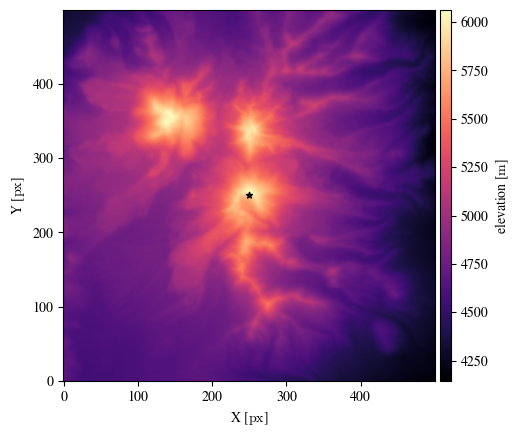

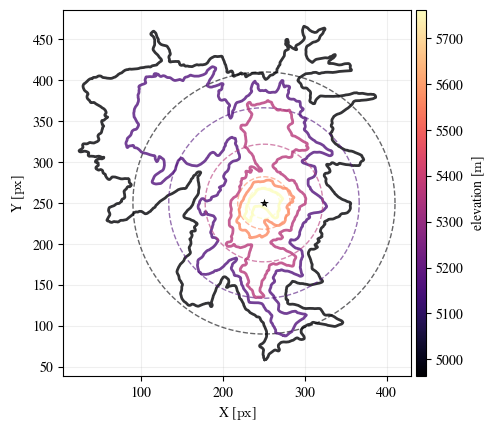

Finished processing!
=== Fifteen most axisymmetric stratovolcanoes ===
 1. Acamarachi                     0.351227
 2. Acatenango                     0.294254
 3. Acotango                       0.273487


In [ ]:
preprocessor_demo = Preprocessor('stratovolcanoes_demo.json', 'scores_demo.csv')
_ = preprocessor_demo.get_axisymmetry_scores()

## Full preprocessing

In [ ]:
# All stratovolcanoes with max(elev) > 1000m: 3.17G
file_id = '1FsDODZrZMTt-DG8lsvfGCoxVdJBmpONS'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'stratovolcanoes_all.json', quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1FsDODZrZMTt-DG8lsvfGCoxVdJBmpONS
From (redirected): https://drive.google.com/uc?id=1FsDODZrZMTt-DG8lsvfGCoxVdJBmpONS&confirm=t&uuid=1fea200f-c49a-4df4-86ec-38806bd1fbd3
To: /content/stratovolcanoes_all.json
100%|██████████| 3.17G/3.17G [00:26<00:00, 120MB/s] 


'stratovolcanoes_all.json'

In [ ]:
preprocessor = Preprocessor('stratovolcanoes_all.json', 'scores_all.csv')
preprocessor.config.verbose = False
_ = preprocessor.get_axisymmetry_scores()

Loading from stratovolcanoes_all.json
Processed 50 volcanoes...
Processed 100 volcanoes...
Processed 150 volcanoes...
Processed 200 volcanoes...
Processed 250 volcanoes...
Processed 300 volcanoes...
Processed 350 volcanoes...
Processed 400 volcanoes...
Processed 450 volcanoes...
Processed 500 volcanoes...
Processed 550 volcanoes...
Finished processing!
=== Fifteen most axisymmetric stratovolcanoes ===
 1. Mayon                          0.841220
 2. San Miguel                     0.824371
 3. Chiliques                      0.818873
 4. Cotopaxi                       0.808300
 5. Mount Sumbing                  0.789843
 6. Concepción                     0.784128
 7. Mount Sundoro                  0.778217
 8. Agua                           0.775594
 9. Merelava                       0.771476
10. Inierie                        0.746074
11. Arenal                         0.735741
12. Mount Masaraga                 0.735712
13. Lewotolo                       0.732586
14. Láscar             

In [ ]:
top_n = 50
high_score_names = set()
with open('scores_all.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for i, row in enumerate(reader):
        if i >= top_n:
            break
        name, _ = row
        high_score_names.add(name)

input_path = 'stratovolcanoes_all.json'
output_path = 'stratovolcanoes_best.json'

with open(input_path, 'rb') as infile, open(output_path, 'w') as outfile:
    outfile.write('{\n')
    first_written = True

    for volcano_name, elevation_matrix in ijson.kvitems(infile, ''):
        if volcano_name in high_score_names:
            if not first_written:
                outfile.write(',\n')
            outfile.write(f'  {json.dumps(volcano_name)}: ')

            elevation_matrix_float = np.array(elevation_matrix, dtype=float).tolist()

            json.dump(elevation_matrix_float, outfile, indent=2)
            first_written = False

    outfile.write('\n}\n')

In [ ]:
preprocessor = Preprocessor('stratovolcanoes_best.json', 'scores_best.csv')
preprocessor.config.verbose = True

_ = preprocessor.get_axisymmetry_scores()

# Data analysis

We analyze elevation data of the most symmetric stratovolcanoes to obtain their average radial profiles.

Given a dictionary of elevation matrices (each covering a `sidelength` × `sidelength` area), we

1. Interpolate each matrix to a square grid of size `resolution` × `resolution`.

2. Find the axis of symmetry (typically the summit) in pixel-coordinates.

3. Crop to the largest inscribed circle (so that all radial cross‐sections have the same physical radius).

4. Sample `num_sections` radial profiles around the axis of symmetry.

5. Detect anomalies, then average the good cross‐sections.

5. Average the cross-sections to obtain a mean elevation profile as a function of physical radius (in meters).

In [ ]:
class AnalysisConfig:
    sidelength: int = 20000
    threshold_drop: float = 300
    num_sections: int = 64
    resolution: int = 500
    anomaly_threshold: float = 1.0
    verbose: bool = True
    saveplot: Optional[Literal["pdf", "png", "svg"]] = None

class Analyzer(Preprocessor):
    def __init__(self, data: Dict[str, np.ndarray]) -> None:
        self.data = data
        self.config = AnalysisConfig()
        self.pixel_size = self.config.sidelength / self.config.resolution  # meters per pixel

    def _sample_radial_sections(self, matrix: np.ndarray, center: Tuple[int, int], radius_pix: int) -> List[np.ndarray]:
        cx, cy = center
        N = self.config.resolution
        thetas = np.linspace(0, 2 * np.pi, self.config.num_sections, endpoint=False)
        r_vals = np.linspace(0, radius_pix, N)
        radial_sections: List[np.ndarray] = []
        for theta in thetas:
            xs = cx + r_vals * np.cos(theta)
            ys = cy + r_vals * np.sin(theta)
            coords = np.vstack([ys, xs])
            cs = map_coordinates(matrix, coords, order=1, mode="nearest")
            radial_sections.append(cs.astype(np.float64))
        return radial_sections

    def _filter_anomalous_profiles(self, profiles: List[np.ndarray]) -> List[bool]:
        all_metrics = [self._compute_profile_metrics(profile) for profile in profiles]

        metric_arrays = {
            key: np.array([m[key] for m in all_metrics])
            for key in all_metrics[0]
        }

        medians = {key: np.median(values) for key, values in metric_arrays.items()}
        mads = {
            key: np.median(np.abs(values - medians[key]))
            for key, values in metric_arrays.items()
        }

        keep_flags = []
        for metrics in all_metrics:
            anomaly_score = 0.0
            for key, value in metrics.items():
                deviation = abs(value - medians[key]) / (mads[key] + 1e-10)
                anomaly_score += deviation

            anomaly_score /= len(metrics)
            keep_flags.append(anomaly_score < self.config.anomaly_threshold)

        return keep_flags

    def _average_cross_sections(self, cross_sections: List[np.ndarray], radius_m: float, name: str) -> Tuple[np.ndarray, np.ndarray]:
        kept_flags = self._filter_anomalous_profiles(cross_sections)
        kept = [cs for cs, flag in zip(cross_sections, kept_flags) if flag]
        num_filtered = len(cross_sections) - len(kept)
        filtered_percent = 100.0 * num_filtered / len(cross_sections)

        if self.config.verbose:
            fontsize = 12
            print(f"Filtered out {filtered_percent:.1f}% of cross‐sections")
            plt.figure(figsize=(8, 5))
            rs = np.linspace(0, radius_m, self.config.resolution)
            first_gray = True
            for i, cs in enumerate(cross_sections):
                if not kept_flags[i]:
                    if first_gray:
                        plt.plot(rs, cs, color="lightgray", alpha=1, label="discarded sections")
                        first_gray = False
                    else:
                        plt.plot(rs, cs, color="lightgray", alpha=0.7)
            first_blue = True
            for i, cs in enumerate(cross_sections):
                if kept_flags[i]:
                    if first_blue:
                        plt.plot(rs, cs, color="C0", alpha=1, label="kept sections")
                        first_blue = False
                    else:
                        plt.plot(rs, cs, color="C0", alpha=1)
            plt.grid(True, alpha=0.5)
            plt.xlabel(r"radial coordinate [$\text{m}$]", fontsize=fontsize)
            plt.ylabel(r"elevation [$\text{m}$]", fontsize=fontsize)
            plt.xlim(0,radius_m)
            ax = plt.gca()
            ax.set_aspect('equal', adjustable='box')
            plt.legend(fontsize=fontsize)
            if self.config.saveplot:
                ext = self.config.saveplot
                plt.savefig(f'cross_sections_{name}.{ext}', format=f'{ext}', dpi=300, bbox_inches='tight')


            plt.show()

        stacked = np.vstack(kept)
        avg = np.nanmean(stacked, axis=0)
        std = np.nanstd(stacked, axis=0)# / np.sqrt(self.config.num_sections)
        return avg, std

    def _compute_profile_metrics(self, profile: np.ndarray) -> Dict[str, float]:
        p_min, p_max = profile.min(), profile.max()
        if p_max > p_min:
            normalized = (profile - p_min) / (p_max - p_min)
        else:
            normalized = np.zeros_like(profile)

        peaks = signal.find_peaks(normalized, height=0.5, distance=10)[0]
        num_peaks = len(peaks)

        if np.allclose(profile, profile.min(), atol=1e-8):
            profile_skew = 0.0
            profile_kurt = 0.0
        else:
            profile_skew = skew(profile)
            profile_kurt = kurtosis(profile)

        return {
            'num_peaks': num_peaks,
            'skewness': profile_skew,
            'kurtosis': profile_kurt,
            'roughness': np.sum(np.abs(np.diff(profile))),
            'area': np.trapezoid(profile)
        }

    def _analyze(self, name: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        raw = np.array(self.data[name])
        mat = super()._interpolate(raw, self.config.resolution)
        x0_f, y0_f = super()._find_center(mat)
        x0 = float(x0_f)
        y0 = float(y0_f)

        if self.config.verbose:
            print(f"==={name}===")
            print(f"Center (px):  ({x0:.2f}, {y0:.2f})")

        cropped, radius_pix = self._crop_matrix(mat, (x0, y0))

        if self.config.verbose:
            print(f"Cropped to square size {2*radius_pix} × {2*radius_pix} px")

        cross_sections = self._sample_radial_sections(cropped, (radius_pix, radius_pix), radius_pix)

        radius_m = radius_pix * self.pixel_size
        avg_profile, std_profile = self._average_cross_sections(cross_sections, radius_m, name)

        distances_m = np.linspace(0.0, radius_m, self.config.resolution)

        if self.config.verbose:
            fontsize = 12
            plt.figure(figsize=(8, 5))
            plt.plot(distances_m, avg_profile, color="C0", label="average profile")
            plt.fill_between(distances_m, avg_profile - std_profile, avg_profile + std_profile,
                             color="C0", alpha=0.2, label="±1 std")
            plt.grid(True, alpha=0.5)
            plt.xlabel(r"radial coordinate [$\text{m}$]", fontsize=fontsize)
            plt.ylabel(r"elevation [$\text{m}$]", fontsize=fontsize)
            plt.xlim(0,radius_m)
            plt.legend(fontsize=fontsize)
            ax = plt.gca()
            ax.set_aspect('equal', adjustable='box')

            if self.config.saveplot:
                ext = self.config.saveplot
                plt.savefig(f'average_{name}_profile.{ext}', format=f'{ext}', dpi=300, bbox_inches='tight')

            plt.show()

        return distances_m, avg_profile, std_profile


    def analyze_all(self) -> Dict[str, Tuple[np.ndarray, np.ndarray, np.ndarray]]:
        result = {}
        for name, _ in self.data.items():
            result[name] = self._analyze(name)
        return result

In [ ]:
file_id = '1i_zkbS74IU4JilqQ67dWd0TzaZxINHaM'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'stratovolcanoes_best.json', quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1i_zkbS74IU4JilqQ67dWd0TzaZxINHaM
From (redirected): https://drive.google.com/uc?id=1i_zkbS74IU4JilqQ67dWd0TzaZxINHaM&confirm=t&uuid=3bc21273-490a-4645-af57-bb2716b89701
To: /content/stratovolcanoes_best.json
100%|██████████| 205M/205M [00:03<00:00, 66.5MB/s]


'stratovolcanoes_best.json'

In [ ]:
with open('stratovolcanoes_best.json') as file:
    best_volcanoes = json.load(file)

===Mayon===
Center (px):  (251.54, 253.28)
Cropped to square size 490 × 490 px
Filtered out 34.4% of cross‐sections


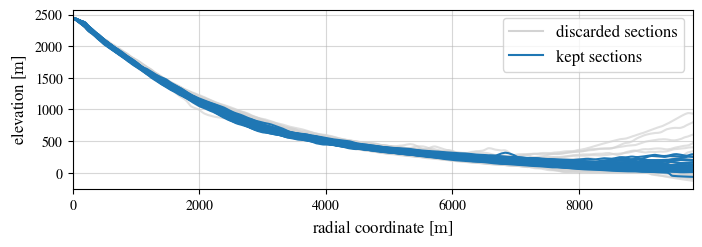

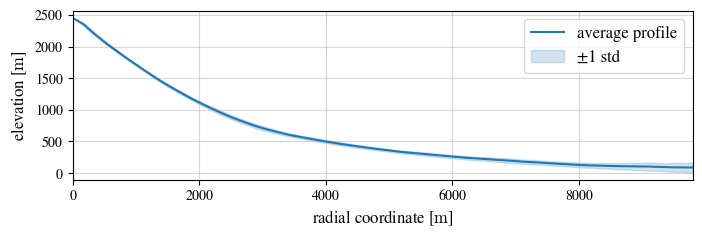

In [ ]:
analyzer = Analyzer(data=best_volcanoes)
analyzer.config.saveplot="svg"

distances_m, avg_profile, std_profile = analyzer._analyze("Mayon")

In [ ]:
output_path = 'analysis_results.json'

analyzer.config.verbose = False
analyzer.config.saveplot = None
analyzer.config.num_sections = 128
result = analyzer.analyze_all()

converted_result = {
    name: (dist_arr.tolist(), avg_arr.tolist(), std_arr.tolist())
    for name, (dist_arr, avg_arr, std_arr) in result.items()
}

with open(output_path, 'w') as outfile:
    json.dump(converted_result, outfile, indent=2)

print(f"Analysis results saved to '{output_path}'")

Analysis results saved to 'analysis_results.json'


# Model fit

In [3]:
file_id = '1JBBieUIOwoI74UVxmrImtKJoMsYl22as'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'analysis_results.json', quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1JBBieUIOwoI74UVxmrImtKJoMsYl22as
To: /content/analysis_results.json
100%|██████████| 1.90M/1.90M [00:00<00:00, 47.6MB/s]


'analysis_results.json'

**Model**
$$ \frac{R^2-r^2}{Rr} = \xi\left(1 + \xi^2\right)\text{Da}^3, \quad \xi = -z'(r), \quad z(R) = z_R $$
**Approximation**
$$  z(r) \approx z_0 - \frac{3}{2C} r^{2/3} + \frac{C}{4} r^{4/3}, \quad \quad C = \frac{\text{Da}}{R^{1/3}} $$

In [4]:
class Model:
    """Class for modeling axisymmetric profile solutions and plotting them."""

    def __init__(self, saveplot: Optional[Literal["pdf", "png", "svg"]] = None) -> None:
        self.saveplot = saveplot

    def _z_approx(self, r: np.ndarray, C: float, z0: float) -> np.ndarray:
        """Approximate analytical solution for z(r)."""
        return z0 - (3 * np.cbrt(r**2)) / (2 * C) + (C * np.cbrt(r**4)) / 4

    def _z_full(self, Da: float, R: float, z_R: float) -> Tuple[np.ndarray, np.ndarray]:
        """Full numerical solution for z(r) by integrating the tan(θ) profile."""

        def tan_theta(r: np.ndarray, R: float) -> np.ndarray:
            lhs = (R**2 - r**2) / (R * r * Da**3)
            Delta = np.sqrt(3 * (27 * lhs**2 + 4))
            Gamma = Delta + 9 * lhs
            epsilon = 1e-10
            return np.cbrt(Gamma / 18) - np.cbrt(2 / (3 * Gamma + epsilon))

        rs = np.linspace(1e-6, R, 10000)
        fvals = tan_theta(rs, R)
        integral_rev = -cumulative_trapezoid(fvals[::-1], rs[::-1], initial=0)
        zs = integral_rev[::-1]
        return rs, zs + z_R

    def _plot(self, Da: float, R: float, z_R: float, fontsize: int = 12) -> None:
        """Plot both the full numerical solution and the approximate solution."""
        rs, zs = self._z_full(Da, R, z_R)
        C = Da / R**(1/3)
        p0 = [np.max(zs)]

        weights = np.ones_like(rs)
        weights[len(weights) // 5:] = 1e-12

        popt, _ = curve_fit(
            lambda r, z0: self._z_approx(r, C, z0),
            rs,
            zs,
            sigma=1.0 / weights,
            p0=p0,
            maxfev=5000,
            method='lm'
        )

        z0 = popt[0]
        approx = self._z_approx(rs, C, z0)

        fig, ax = plt.subplots(figsize=(8, 5))
        n = len(rs) // 2
        ax.plot(rs[:n], approx[:n], label=r'approximation $\varsigma(\varrho)$', color='C2')
        ax.plot(rs, zs, label=r'full solution $\zeta(\varrho)$', color='C1')

        ax.set_xlabel(r'dimensionless radial coordinate $\varrho$', fontsize=fontsize)
        ax.set_ylabel(r'dimensionless axial coordinate $\zeta$', fontsize=fontsize)
        ax.legend(fontsize=fontsize)
        ax.grid(alpha=0.2)
        ax.set_aspect('equal', adjustable='box')
        ax.tick_params(labelsize=fontsize)

        if self.saveplot:
            ext = self.saveplot
            plt.savefig(f'model.{ext}', format=f'{ext}', dpi=300, bbox_inches='tight')

        plt.show()


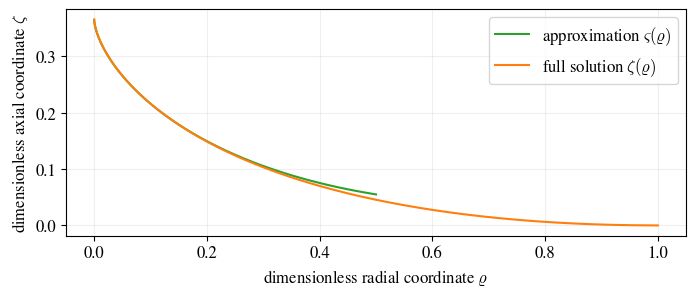

In [ ]:
model = Model(saveplot="pdf")
_ = model._plot(Da=1.9, R=1, z_R=0)

In [5]:
def _format_val_err(val: float, err: float, sig_figs: int = 1) -> str:
    if err <= 0 or np.isnan(err):
        return f"{val:.{sig_figs+1}f}(0)"

    exponent = int(np.floor(np.log10(err)))
    factor = 10**(exponent - (sig_figs - 1))
    err_rounded = round(err / factor) * factor
    exponent_rounded = int(np.floor(np.log10(err_rounded)))
    decimal_places = max(0, -exponent_rounded)
    val_rounded = round(val, decimal_places)
    err_int = int(round(err_rounded * (10**decimal_places)))

    return f"{val_rounded:.{decimal_places}f}({err_int})"


class Fitter(Model):
    def __init__(
        self,
        data: Optional[Dict[str, Tuple[np.ndarray, np.ndarray, np.ndarray]]] = None,
        verbose: bool = True,
        saveplot: Optional[Literal["pdf", "png", "svg"]] = None,
    ) -> None:
        self.data = data or {}
        self.saveplot = saveplot
        self.verbose = verbose

        logging.basicConfig(
            level=logging.INFO if self.verbose else logging.WARNING,
            format='%(message)s'
        )
        self.logger = logging.getLogger(__name__)

    def _z_full_fit(self, rs: np.ndarray, Da: float, R: float, z_R: float) -> np.ndarray:
        rs_mod, zs = super()._z_full(Da, R, z_R)
        return np.interp(rs, rs_mod, zs)

    def _z_approx_fit(self, rs: np.ndarray, C: float, z_0: float) -> np.ndarray:
        return super()._z_approx(rs, C, z_0)

    def fit_full_single(self, name: str, crater_cut: float = 0.04) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        if name not in self.data:
            self.logger.error(f"Data for '{name}' not found.")
            return None

        rs, elevation, std = [np.asarray(_, dtype=float) for _ in self.data[name]]

        r_min = crater_cut * rs.max()
        mask = rs >= r_min

        p0 = [1, rs.max(), np.min(elevation)]  # Da, R, z_R

        try:
            popt, pcov = curve_fit(
                self._z_full_fit,
                rs[mask],
                elevation[mask],
                sigma=std[mask],
                p0=p0,
                maxfev=10000,
                method='lm'
            )
        except Exception as e:
            self.logger.error(f"Curve-fit failed for '{name}': {e}")
            return None

        Da_fit, R_fit, z_R_fit = popt
        Da_err, R_err, z_R_err = np.sqrt(np.diag(pcov))
        fitted_vals = self._z_full_fit(rs, *popt)

        residuals = elevation[mask] - fitted_vals[mask]
        chi2 = np.sum((residuals / std[mask]) ** 2)
        dof = np.sum(mask) - len(popt)
        chi2red = chi2 / dof if dof > 0 else np.inf

        stat = (chi2, dof, chi2red)

        if self.verbose:
            self._log_full_fit_results(name, popt, [Da_err, R_err, z_R_err], stat)
            self._plot_full_fit(name, rs, elevation, std, fitted_vals, r_min,
                              popt, [Da_err, R_err, z_R_err], R_fit)

        return popt, pcov, stat

    def fit_approx_single(self, name: str, crater_cut: float = 0.04, tail_cut: float = 0.6) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        if name not in self.data:
            self.logger.error(f"Data for '{name}' not found.")
            return None

        rs, elevation, std = [np.asarray(_, dtype=float) for _ in self.data[name]]

        r_min = crater_cut * rs.max()
        r_max = tail_cut * rs.max()
        mask = (rs >= r_min) & (rs <= r_max)

        p0 = [0.1, np.max(elevation)]  # C, z_0

        try:
            popt, pcov = curve_fit(
                self._z_approx,
                rs[mask],
                elevation[mask],
                sigma=std[mask],
                p0=p0,
                maxfev=10000,
                method='lm'
            )
        except Exception as e:
            self.logger.error(f"Curve-fit failed for '{name}': {e}")
            return None

        C_fit, z_0_fit = popt
        C_err, z_0_err = np.sqrt(np.diag(pcov))
        fitted_vals = self._z_approx(rs, *popt)

        residuals = elevation[mask] - fitted_vals[mask]
        chi2 = np.sum((residuals / std[mask]) ** 2)
        dof = np.sum(mask) - len(popt)
        chi2red = chi2 / dof if dof > 0 else np.inf

        stat = (chi2, dof, chi2red)

        if self.verbose:
            self._log_approx_fit_results(name, popt, [C_err, z_0_err], stat)
            self._plot_approx_fit(name, rs, elevation, std, fitted_vals,
                                r_min, r_max, popt, [C_err, z_0_err])

        return popt, pcov, stat

    def fit_all_full(self, crater_cut: float = 0.04) -> Dict[str, Tuple[float, float]]:
        filtered_das = []
        statistics = {}

        for name in self.data:
            result = self.fit_full_single(name, crater_cut=crater_cut)
            if result is not None:
                popt, pcov, stat = result
                chi2, dof, chi2red = stat
                Da_err = np.sqrt(np.diag(pcov))[0]

                if Da_err < 1:
                    filtered_das.append(popt[0])

                statistics[name] = chi2red

        if filtered_das:
            self._plot_da_histogram(filtered_das)

        self._display_top_fits(statistics, "full")
        self._save_statistics(statistics)

        return statistics

    def fit_all_approx(
        self,
        crater_cut: float = 0.04,
        tail_cut: float = 0.6
    ) -> Dict[str, float]:
        statistics = {}

        for name in self.data:
            result = self.fit_approx_single(name, crater_cut=crater_cut, tail_cut=tail_cut)
            if result is not None:
                popt, pcov, stat = result
                chi2, dof, chi2_red = stat
                statistics[name] = chi2_red

        self._display_top_fits(statistics, "approx")
        self._save_statistics(statistics)

        return statistics

    def _log_full_fit_results(self, name: str, popt: np.ndarray, errors: list, stat: tuple):
        """Log the results of a full model fit."""
        Da_fit, R_fit, z_R_fit = popt
        chi2, dof, chi2red = stat

        self.logger.info(f"==={name}===")
        self.logger.info(f"  Da    = {Da_fit:.6f}")
        self.logger.info(f"  R     = {R_fit:.6f}")
        self.logger.info(f"  z(R)  = {z_R_fit:.6f}")
        self.logger.info(f"  χ²    = {chi2:.6f}")
        self.logger.info(f"  dof   = {dof:.0f}")
        self.logger.info(f"  χ²red = {chi2red:.6f}")

    def _log_approx_fit_results(self, name: str, popt: np.ndarray, errors: list, stat: tuple):
        """Log the results of an approximate model fit."""
        C_fit, z_0_fit = popt
        chi2, dof, chi2red = stat

        self.logger.info(f"==={name}===")
        self.logger.info(f"  Da/R^(1/3) = {C_fit:.6f}")
        self.logger.info(f"  z(0)       = {z_0_fit:.6f}")
        self.logger.info(f"  χ²         = {chi2:.6f}")
        self.logger.info(f"  dof        = {dof:.0f}")
        self.logger.info(f"  χ²red      = {chi2red:.6f}")

    def _plot_full_fit(self, name: str, rs: np.ndarray, elevation: np.ndarray,
                      std: np.ndarray, fitted_vals: np.ndarray, r_min: float,
                      popt: np.ndarray, errors: list, R_fit: float):
        """Create a plot for the full model fit."""
        Da_fit, R_fit, z_R_fit = popt
        Da_err, R_err, z_R_err = errors

        plt.figure(figsize=(9, 6))
        ax = plt.gca()

        plt.axvline(r_min, linestyle='-.', label='fit limit', color='C1', alpha=0.7)
        plt.plot(rs[1:], fitted_vals[1:], 'C1', label=r"$\zeta$ model fit")
        plt.plot(rs, elevation, 'C0', label="average profile")
        plt.fill_between(
            rs,
            elevation + std,
            elevation - std,
            color='C0',
            alpha=0.2,
            label=r"$\pm$ std"
        )

        plt.xlabel(r"radial coordinate $r$ [m]", fontsize=12)
        plt.ylabel(r"axial coordinate $z$ [m]", fontsize=12)
        plt.xlim(0, min(rs[-1], R_fit))
        plt.title(name, fontsize=14)
        plt.grid(alpha=0.5)
        plt.legend(fontsize=12, loc='upper right')

        Da_str = _format_val_err(Da_fit, Da_err)
        R_str = _format_val_err(R_fit, R_err)
        z_R_str = _format_val_err(z_R_fit, z_R_err)

        textstr = '\n'.join((
            r'$\text{Da}=%s$' % Da_str,
            r'$R=%s \;\text{m}$' % R_str,
            r'$z_R=%s \;\text{m}$' % z_R_str
        ))

        props = dict(boxstyle='round', facecolor='white', alpha=1)
        ax.text(0.02, 0.05, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='bottom', bbox=props)

        ax.set_aspect('equal', adjustable='box')
        plt.tight_layout()

        if self.saveplot:
            plt.savefig(f"{name}_fit.{self.saveplot}", format=self.saveplot,
                       dpi=300, bbox_inches='tight')

        plt.show()

    def _plot_approx_fit(self, name: str, rs: np.ndarray, elevation: np.ndarray,
                        std: np.ndarray, fitted_vals: np.ndarray, r_min: float,
                        r_max: float, popt: np.ndarray, errors: list):
        """Create a plot for the approximate model fit."""
        C_fit, z_0_fit = popt
        C_err, z_0_err = errors

        plt.figure(figsize=(9, 6))
        ax = plt.gca()

        plt.axvline(r_min, linestyle='-.', label='fit limit', color='C1', alpha=0.7)
        if r_max < rs[-1]:
            plt.axvline(r_max, linestyle='-.', color='C1', alpha=0.7)

        plt.plot(rs, fitted_vals, 'C2', label=r"$\varsigma$ approximation fit")
        plt.plot(rs, elevation, 'C0', label="average profile")
        plt.fill_between(
            rs,
            elevation + std,
            elevation - std,
            color='C0',
            alpha=0.2,
            label=r"$\pm$ std"
        )

        plt.xlabel(r"radial coordinate $r$ [m]", fontsize=12)
        plt.ylabel(r"axial coordinate $z$ [m]", fontsize=12)
        plt.xlim(0, rs[-1])#min(rs[-1], r_max))
        plt.title(name, fontsize=14)
        plt.grid(alpha=0.5)
        plt.legend(fontsize=12, loc='upper right')

        C_str = _format_val_err(C_fit, C_err)
        z_0_str = _format_val_err(z_0_fit, z_0_err)

        textstr = '\n'.join((
            r'$\text{Da}R^{-1/3}=%s$' % C_str,
            r'$z_0=%s \;\text{m}$' % z_0_str
        ))

        props = dict(boxstyle='round', facecolor='white', alpha=1)
        ax.text(0.02, 0.05, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='bottom', bbox=props)

        ax.set_aspect('equal', adjustable='box')
        plt.tight_layout()

        if self.saveplot:
            plt.savefig(f"{name}_approx_fit.{self.saveplot}", format=self.saveplot,
                       dpi=300, bbox_inches='tight')

        plt.show()

    def _plot_da_histogram(self, filtered_das: list):
        """Create a histogram of Da values."""
        fontsize = 12

        plt.figure(figsize=(5, 4))
        mean_da = np.mean(filtered_das)
        std_da = np.std(filtered_das)

        import matplotlib.colors as mcolors
        c0_rgb = mcolors.to_rgb('C0')

        def lighten_color(color, amount=0.5):
            return tuple(1 - (1 - c) * amount for c in color)

        light_c0 = lighten_color(c0_rgb, amount=0.7)

        plt.axvline(mean_da, color='C0', linestyle='-.', label=f"mean = {mean_da:.2f}")

        plt.hist(
          filtered_das,
          bins=10,
          edgecolor='C0',
          color=light_c0,
          alpha=1
        )

        plt.legend(fontsize=fontsize)
        plt.xlabel(r"value of fitted parameter $\text{Da}$", fontsize=fontsize)
        plt.ylabel("number of appearances", fontsize=fontsize)

        da_min, da_max = min(filtered_das), max(filtered_das)
        tick_spacing = (da_max - da_min) / 10
        plt.xticks(np.arange(da_min, da_max + tick_spacing, tick_spacing))
        plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        plt.tight_layout()

        plt.savefig("Das.pdf", format="pdf", dpi=300, bbox_inches='tight')
        plt.show()

    def _display_top_fits(self, statistics: dict, fit_type: str):
        """Display the top 15 fits by chi-squared metric."""
        if fit_type == "full":
            top15 = sorted(statistics.items(), key=lambda item: abs(1 - item[1]))[:15]
            print("=== Top 15 full fits by |1 - χ²_red| ===")
            for name, chi2_red in top15:
                print(f"{name}: χ²_red = {chi2_red:.6f}")
        else:
            top15 = sorted(statistics.items(), key=lambda item: abs(1 - item[1]))[:15]
            print("=== Top 15 approx fits by |1 - χ²_red| ===")
            for name, chi2_red in top15:
                print(f"{name}: χ²_red = {chi2_red:.6f}")

    def _save_statistics(self, statistics: dict):
        """Save statistics to JSON file."""
        try:
            with open("statistics.json", "w") as f:
                json.dump(statistics, f, indent=2)
        except Exception as e:
            self.logger.error(f"Failed to save statistics: {e}")

===Mayon===
  Da    = 1.952081
  R     = 8258.115327
  z(R)  = 142.118437
  χ²    = 444.542467
  dof   = 477
  χ²red = 0.931955


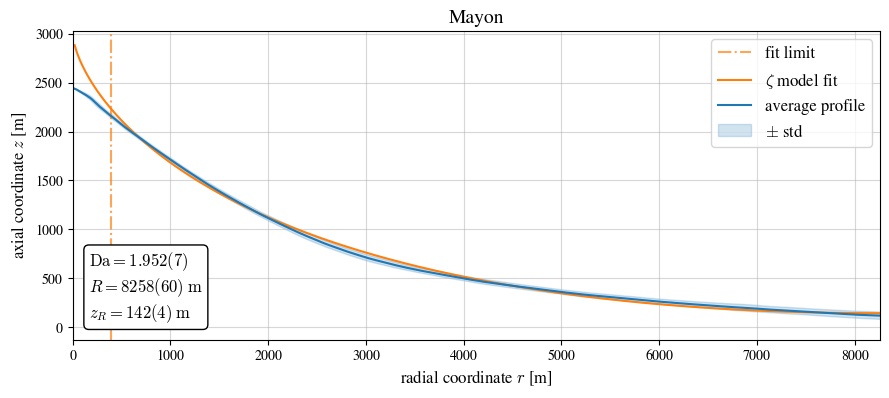

In [6]:
def main():
    with open('analysis_results.json', 'r') as file:
        data = json.load(file)

    fitter = Fitter(data=data, verbose=True, saveplot=None)

    _ = fitter.fit_full_single("Mayon", 0.04)
    #_ = fitter.fit_full_single("Mount Fuji", 0.08)
    #_ = fitter.fit_approx_single("Mayon", 0.04, 0.6)
    #_ = fitter.fit_approx_single("Láscar", 0.04, 0.6)

    #statistics_full = fitter.fit_all_full(crater_cut=0.04)
    #statistics_approx = fitter.fit_all_approx(crater_cut=0.04, tail_cut=0.6)

main()

# Lacey et al. comparison

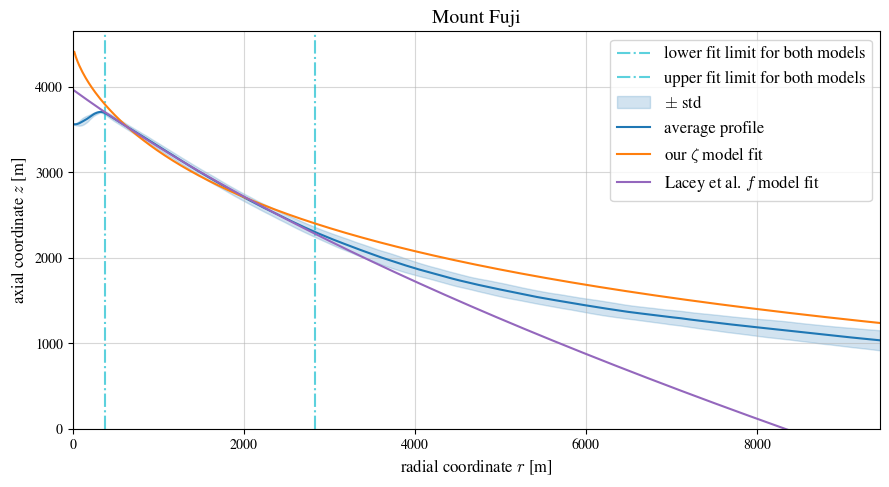

In [24]:
class Comparator(Fitter):
    def __init__(
        self,
        data: Optional[Dict[str, Tuple[np.ndarray, np.ndarray, np.ndarray]]] = None,
        verbose: bool = True,
        saveplot: Optional[Literal["pdf", "png", "svg"]] = None,
    ) -> None:
        self.data = data or {}
        self.saveplot = saveplot
        self.verbose = verbose

        logging.basicConfig(
            level=logging.INFO if self.verbose else logging.WARNING,
            format='%(message)s'
        )
        self.logger = logging.getLogger(__name__)

    def _f(self, eta0: float, eta_min: float = 1e-6) -> Tuple[np.ndarray, np.ndarray]:
        def ode_system(eta, y):
            f, f_prime = y
            if eta < 1e-10:
                eta = 1e-10
            f_double_prime = - f_prime**2/(f + 1e-10) - f_prime/eta - 0.5*eta*f_prime/(f + 1e-10)
            return [f_prime, f_double_prime]

        f0 = 0.0
        eta0 = max(eta0, 1e-6)
        f0_prime = -0.5 * eta0
        y0 = [f0, f0_prime]

        eta_span = (eta0, eta_min)
        eta_eval = np.linspace(eta0, eta_min, 1000)

        try:
            sol = solve_ivp(ode_system, eta_span, y0, t_eval=eta_eval,
                            method='RK45', rtol=1e-8, atol=1e-10)

            if sol.success:
                eta_vals = sol.t[::-1]
                f_vals = sol.y[0][::-1]

                dfs = np.gradient(f_vals, eta_vals)
                dfs_smooth = uniform_filter1d(dfs, size=5)
                threshold = 1e-1

                drop_index = len(dfs_smooth)
                for i in range(len(dfs_smooth) - 1, 0, -1):
                    if abs(dfs_smooth[i]) > threshold:
                        drop_index = i + 1
                        break

                etas_trimmed = eta_vals[:drop_index]
                fs_trimmed = f_vals[:drop_index]

                return etas_trimmed, fs_trimmed

        except Exception as e:
            print(f"Error solving ODE: {e}")
            return None, None

    def _f_fit(self,
              rs: np.ndarray,
              A: float,     # vertical scale
              B: float,     # horizontal scale
              R: float,     # horizontal offset
              C: float,     # vertical offset
              eta0: float = 1.16,
              ) -> np.ndarray:
        eta_vals, f_vals = self._f(eta0)

        if eta_vals is None or f_vals is None:
            raise RuntimeError(f"ODE solution failed for eta0={eta0}")

        r_mod = B * eta_vals + R
        z_mod = A * f_vals + C

        dfs = np.gradient(z_mod, r_mod)
        dfs_smooth = uniform_filter1d(dfs, size=5)
        threshold = 1e-1

        drop_index = len(dfs_smooth)
        for i in range(len(dfs_smooth) - 1, 0, -1):
            if abs(dfs_smooth[i]) > threshold:
                drop_index = i + 1
                break

        r_mod = r_mod[:drop_index]
        z_mod = z_mod[:drop_index]

        z_out = np.interp(rs, r_mod, z_mod,
                  left=np.nan,
                  right=np.nan)
        return z_out

    def compare_single(self, name: str, crater_cut: float = 0.04, tail_cut = 0.3) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        if name not in self.data:
            self.logger.error(f"Data for '{name}' not found.")
            return None

        rs, elevation, std = [np.asarray(_, dtype=float) for _ in self.data[name]]

        r_min = crater_cut * rs.max()
        r_max = tail_cut * rs.max()
        mask2 = (rs >= r_min) & (rs <= r_max)

        p0 = [1e4, 1e4, 0, np.min(elevation)]  # A, B, r0, C

        popt, pcov = curve_fit(
            self._f_fit,
            rs[mask2],
            elevation[mask2],
            sigma=std[mask2],
            p0=p0,
            maxfev=10000,
            method='lm'
        )

        A_fit, B_fit, r0_fit, C_fit = popt
        fitted_vals = self._f_fit(rs, *popt)

        s0 = [1, rs.max(), np.min(elevation)]  # Da, R, z_R

        mask = rs >= r_min

        popt_us, pcov_us = curve_fit(
            self._z_full_fit,
            rs[mask2],
            elevation[mask2],
            sigma=std[mask2],
            p0=s0,
            maxfev=10000,
            method='lm'
        )

        Da_fit, R_fit, z_R_fit = popt_us
        fitted_vals_us = self._z_full_fit(rs, *popt_us)

        if self.verbose:
            self._plot_comparison(name, fitted_vals_Lacey=fitted_vals, popt_Lacey=popt, fitted_vals_us=fitted_vals_us, popt_us=popt_us, r_min=r_min, r_max=r_max)

        return popt, pcov

    def _plot_comparison(self,
                         name: str,
                         fitted_vals_Lacey: np.ndarray,
                         popt_Lacey: np.ndarray,
                         fitted_vals_us: np.ndarray,
                         popt_us: np.ndarray,
                         r_min: float,
                         r_max: float):
        """Create a plot for the full model fit."""
        rs, elevation, std = [np.asarray(_, dtype=float) for _ in self.data[name]]

        plt.figure(figsize=(9, 6))
        ax = plt.gca()

        plt.axvline(r_min, linestyle='-.', label=r'lower fit limit for both models', color='C9', alpha=0.7)
        plt.axvline(r_max, linestyle='-.', label='upper fit limit for both models', color='C9', alpha=0.7)
        plt.fill_between(
            rs,
            elevation + std,
            elevation - std,
            color='C0',
            alpha=0.2,
            label=r"$\pm$ std"
        )
        plt.plot(rs, elevation, 'C0', label="average profile")

        plt.plot(rs[1:], fitted_vals_us[1:], 'C1', label=r"our $\zeta$ model fit")
        plt.plot(rs[1:], fitted_vals_Lacey[1:], 'C4', label=r"Lacey et al. $f$ model fit")

        plt.xlabel(r"radial coordinate $r$ [m]", fontsize=12)
        plt.ylabel(r"axial coordinate $z$ [m]", fontsize=12)
        plt.ylim(0, None)
        plt.xlim(0, rs[-1])
        plt.title(name, fontsize=14)
        plt.grid(alpha=0.5)
        plt.legend(fontsize=12, loc='upper right')

        ax.set_aspect('equal', adjustable='box')
        plt.tight_layout()
        plt.savefig(f"{name}_comparison.pdf", format='pdf',
                       dpi=300, bbox_inches='tight')

        plt.show()

def main():
    with open('analysis_results.json', 'r') as file:
        data = json.load(file)

    comparator = Comparator(data=data, verbose=True, saveplot=None)

    _ = comparator.compare_single("Mount Fuji", 0.04, 0.3)

main()

# Photo fit (unfinished)

In [ ]:
file_id = '1EcsKXcFtMOaVzyjG5RuWnWijbEi9X1th'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'mayon.jpg', quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1EcsKXcFtMOaVzyjG5RuWnWijbEi9X1th
To: /content/mayon.jpg
100%|██████████| 1.60M/1.60M [00:00<00:00, 30.8MB/s]


'mayon.jpg'

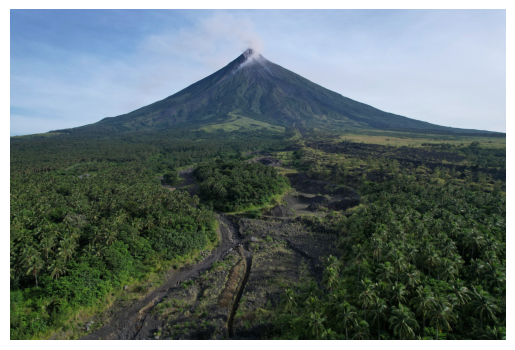

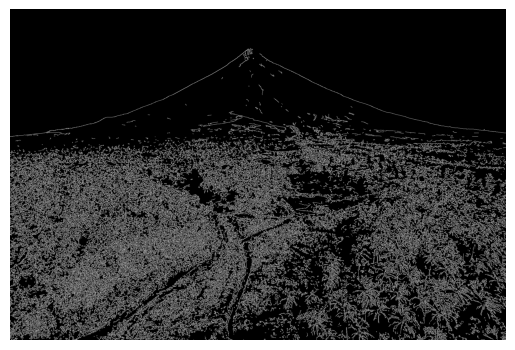

In [ ]:
import matplotlib.pyplot as plt
import cv2

name = "mayon.jpg"

img = cv2.imread(name)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, threshold1=100, threshold2=200)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()